## 分析聯合新聞網總統大選期間相關新聞之詞彙關係

我們組使用聯合新聞網 全球(global)、社會(social)、產經(produce)、股市(stock)、要聞(important) 五個版的資料，並使用TF-IDF, N-gram等方法找出文章以及字詞間的關聯。 

## 1. 載入套件

In [1]:
# ％pip install -U networkx

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import re
import jieba
import jieba.analyse
import math
from nltk import ngrams, FreqDist
from collections import Counter, namedtuple

import networkx as nx
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity
from matplotlib import font_manager

In [3]:
# 設定圖的中文字體 (無法顯示的話可以試試‘Microsoft JhengHei’字體)
# 也可參考：https://pyecontech.com/2020/03/27/python_matplotlib_chinese/
plt.rcParams['font.sans-serif'] = ['Arial Unicode Ms'] #使圖中中文能正常顯示
plt.rcParams['axes.unicode_minus'] = False #使負號能夠顯示

In [4]:
# cloab 字體設定
import matplotlib
# Path to the custom font
font_path = 'font/TraditionalChinese.ttf'

# Add the custom font to the font manager
font_manager.fontManager.addfont(font_path)

# After adding the font, search for it by filename to get the correct font name
for font in font_manager.fontManager.ttflist:
    if font.fname == font_path:
        print(f"Found font: {font.name}")
        plt.rcParams['font.family'] = font.name
        break

Found font: Noto Sans TC


## 2. 資料前處理

### 2.1 基本資料介紹
資料來源：
+ 工作流程平台蒐集聯合新聞網文章
+ 時間: 2024-01-01 ~ 2024-01-13 (總統大選前)
+ 選擇版別: 全球(global)、社會(social)、產經(produce)、股市(stock)、要聞(important)
+ 資料筆數：共 9480 則新聞

In [5]:
#匯入資料
df = pd.read_csv('./data/聯合日報更新2.csv', encoding = 'UTF-8')
df

,system_id,artTitle,artDate,artCatagory,artUrl,artContent,dataSource
0,1,蔡總統主持元旦升旗 國防部長邱國正率將領參加,2024/1/1 10:27,要聞,https://udn.com/news/story/10930/7678307,國防部表示，蔡英文總統上午主持中華民國113年元旦總統府升旗典禮，國防部長邱國正、參謀總長梅...,UDN
1,2,F-16V廠級維修能量今年第一季驗證 台美還在對峙談判中,2024/1/1 10:29,要聞,https://udn.com/news/story/10930/7678314,空軍2025年開始陸續接裝66架F-16C/D BLOCK70戰機，國防部軍備局表示，正透過...,UDN
2,3,義務役新兵看過來 入伍結訓震撼教育攻略圖表在這裡,2024/1/1 11:16,要聞,https://udn.com/news/story/10930/7678409,2024年1月首波徵召入營600名一年制兵役役男，這些役男入伍後，將接受新兵訓練震撼教育。國...,UDN
3,4,國防部：籲法界嚴肅看待暴行、抗命及聚眾鬥毆軍紀案,2024/1/1 13:19,要聞,https://udn.com/news/story/10930/7678652,因應兵役延長一年，國防部今天表示，已配合全國檢察長座談時機，請檢察官嚴肅看待暴行、抗命及聚眾...,UDN
4,5,暴行抗命等軍紀案 國防部：檢察官允速查嚴辦,2024/1/1 17:50,要聞,https://udn.com/news/story/10930/7679055,國軍已恢復一年制義務役，外界關注是否恢復軍事審判制度，國防部今天表示，將在兼顧軍紀維護與人權...,UDN
...,...,...,...,...,...,...,...
9475,9476,長榮、陽明 四檔閃金光,2024/1/12 23:40,股市,https://udn.com/news/story/7255/7704877,紅海危機不斷升溫，造成上海集裝箱出口（SCFI）運價指數周漲幅16.31%，四大航線全面大漲...,UDN
9476,9477,全民權證／力成 押價內外10%,2024/1/12 23:38,股市,https://udn.com/news/story/7255/7704879,力成（6239）去年第4季營運由於DRAM、NAND Flash及Logic等急單挹注情況優...,UDN
9477,9478,全民權證／大立光 選逾120天,2024/1/12 23:37,股市,https://udn.com/news/story/7255/7704881,大立光（3008）2023年營收488.42億元，年增2%，連兩年回溫；稅後純益179.08...,UDN
9478,9479,最牛一輪／文曄出運 群益34叫好,2024/1/12 23:35,股市,https://udn.com/news/story/7255/7704882,"文曄（3036）去年第4季合併營收約新台幣1,897億元，季增13%，年增20%，創單季新高...",UDN


In [6]:
#查看各版筆數分佈
df.groupby('artCatagory').size()

artCatagory
全球    1795
產經    1806
社會    1096
股市    1232
要聞    3551
dtype: int64

### 2.2 資料清理  
- 去除特殊字元與標點符號，只留下中文字
- \u4e00-\u9fff 為Unicode中文漢字字符的範圍

In [7]:
MetaData = df.copy()

# 去除一些不需要的欄位
MetaData = MetaData.drop(['dataSource'], axis=1)
MetaData['artContent'] = MetaData['artContent'].astype(str)
# 只留下中文字
MetaData['sentence'] = MetaData['artContent'].apply(lambda x: re.sub('[^\u4e00-\u9fff]+', '',x))

MetaData.head(3)

,system_id,artTitle,artDate,artCatagory,artUrl,artContent,sentence
0,1,蔡總統主持元旦升旗 國防部長邱國正率將領參加,2024/1/1 10:27,要聞,https://udn.com/news/story/10930/7678307,國防部表示，蔡英文總統上午主持中華民國113年元旦總統府升旗典禮，國防部長邱國正、參謀總長梅...,國防部表示蔡英文總統上午主持中華民國年元旦總統府升旗典禮國防部長邱國正參謀總長梅家樹率將領與...
1,2,F-16V廠級維修能量今年第一季驗證 台美還在對峙談判中,2024/1/1 10:29,要聞,https://udn.com/news/story/10930/7678314,空軍2025年開始陸續接裝66架F-16C/D BLOCK70戰機，國防部軍備局表示，正透過...,空軍年開始陸續接裝架戰機國防部軍備局表示正透過談判爭取由漢翔建立廠級維修中心漢翔公司說維修中...
2,3,義務役新兵看過來 入伍結訓震撼教育攻略圖表在這裡,2024/1/1 11:16,要聞,https://udn.com/news/story/10930/7678409,2024年1月首波徵召入營600名一年制兵役役男，這些役男入伍後，將接受新兵訓練震撼教育。國...,年月首波徵召入營名一年制兵役役男這些役男入伍後將接受新兵訓練震撼教育國防部說明震撼教育訓練場...


### 2.3 文章斷詞與整理

In [8]:
# 設定繁體中文詞庫
jieba.set_dictionary('./dict/dict.txt.big')

# 新增stopwords
with open('./dict/stopwords.txt',encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

In [9]:
# 設定斷詞 function
def getToken(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1] # 篩選掉停用字與字元數小於1的詞彙

    return seg_list

In [10]:
data = MetaData.copy()

# 斷詞、去除停用字並將word欄位展開
data['word'] = data.sentence.apply(getToken).explode('word')

data.head(3)

Building prefix dict from /Users/tsaipingyu/Library/CloudStorage/GoogleDrive-jerryone888@gmail.com/其他電腦/我的筆記型電腦/中山課程_研究所/碩一下/社媒/code/StockNatrakLanguageAnalyze/dict/dict.txt.big ...
Loading model from cache /var/folders/4p/hs58l6r50xd2hy79hrrr3df80000gn/T/jieba.u6266deb903f2f7d97cfe01a4ae1ee235.cache
Loading model cost 0.368 seconds.
Prefix dict has been built successfully.


,system_id,artTitle,artDate,artCatagory,artUrl,artContent,sentence,word
0,1,蔡總統主持元旦升旗 國防部長邱國正率將領參加,2024/1/1 10:27,要聞,https://udn.com/news/story/10930/7678307,國防部表示，蔡英文總統上午主持中華民國113年元旦總統府升旗典禮，國防部長邱國正、參謀總長梅...,國防部表示蔡英文總統上午主持中華民國年元旦總統府升旗典禮國防部長邱國正參謀總長梅家樹率將領與...,國防部
1,2,F-16V廠級維修能量今年第一季驗證 台美還在對峙談判中,2024/1/1 10:29,要聞,https://udn.com/news/story/10930/7678314,空軍2025年開始陸續接裝66架F-16C/D BLOCK70戰機，國防部軍備局表示，正透過...,空軍年開始陸續接裝架戰機國防部軍備局表示正透過談判爭取由漢翔建立廠級維修中心漢翔公司說維修中...,英文
2,3,義務役新兵看過來 入伍結訓震撼教育攻略圖表在這裡,2024/1/1 11:16,要聞,https://udn.com/news/story/10930/7678409,2024年1月首波徵召入營600名一年制兵役役男，這些役男入伍後，將接受新兵訓練震撼教育。國...,年月首波徵召入營名一年制兵役役男這些役男入伍後將接受新兵訓練震撼教育國防部說明震撼教育訓練場...,總統


## 3. 找出重要詞彙 - 以TFIDF為例

TF-IDF 是一種統計方法，可用來評估單詞對於文件的集合的重要程度  
- **TF** (Term Frequency)：某一個詞彙在某一個文件中所出現的頻率  
    - TF = 詞彙在該文件中出現次數 / 該文件中詞彙總數  
- **IDF** (Inverse Document Frequent)：為文件數除以某特定詞彙有被多少文件所提及的數量取log  
    - IDF = log( 總文件數量 / 包含該詞彙的文件數量 ) 

### 3.1 應用於資料集（套件）

In [11]:
udn_df = MetaData.copy()
udn_df.head(3)

,system_id,artTitle,artDate,artCatagory,artUrl,artContent,sentence
0,1,蔡總統主持元旦升旗 國防部長邱國正率將領參加,2024/1/1 10:27,要聞,https://udn.com/news/story/10930/7678307,國防部表示，蔡英文總統上午主持中華民國113年元旦總統府升旗典禮，國防部長邱國正、參謀總長梅...,國防部表示蔡英文總統上午主持中華民國年元旦總統府升旗典禮國防部長邱國正參謀總長梅家樹率將領與...
1,2,F-16V廠級維修能量今年第一季驗證 台美還在對峙談判中,2024/1/1 10:29,要聞,https://udn.com/news/story/10930/7678314,空軍2025年開始陸續接裝66架F-16C/D BLOCK70戰機，國防部軍備局表示，正透過...,空軍年開始陸續接裝架戰機國防部軍備局表示正透過談判爭取由漢翔建立廠級維修中心漢翔公司說維修中...
2,3,義務役新兵看過來 入伍結訓震撼教育攻略圖表在這裡,2024/1/1 11:16,要聞,https://udn.com/news/story/10930/7678409,2024年1月首波徵召入營600名一年制兵役役男，這些役男入伍後，將接受新兵訓練震撼教育。國...,年月首波徵召入營名一年制兵役役男這些役男入伍後將接受新兵訓練震撼教育國防部說明震撼教育訓練場...


In [12]:
# 保留需要的欄位
udn_df = udn_df.loc[:,["system_id", "sentence"]]

# 改成使用空格連接斷完的詞
udn_df['word'] = udn_df.sentence.apply(getToken).map(' '.join)

udn_df.head()

,system_id,sentence,word
0,1,國防部表示蔡英文總統上午主持中華民國年元旦總統府升旗典禮國防部長邱國正參謀總長梅家樹率將領與...,國防部 英文 總統 上午 主持 中華民國 元旦 總統府 升旗典禮 國防部長 邱國正 參謀總長...
1,2,空軍年開始陸續接裝架戰機國防部軍備局表示正透過談判爭取由漢翔建立廠級維修中心漢翔公司說維修中...,空軍 陸續 接裝架 戰機 國防部 軍備 透過 談判 爭取 由漢翔 建立 廠級 維修中心 漢翔...
2,3,年月首波徵召入營名一年制兵役役男這些役男入伍後將接受新兵訓練震撼教育國防部說明震撼教育訓練場...,首波 徵召 入營 一年制 兵役 役男 役男 入伍 後將 接受 新兵訓練 震撼 教育 國防部 ...
3,4,因應兵役延長一年國防部今天表示已配合全國檢察長座談時機請檢察官嚴肅看待暴行抗命及聚眾鬥毆等破...,因應 兵役 延長 一年 國防部 今天 配合 全國 檢察長 座談 時機 檢察官 嚴肅 看待 暴...
4,5,國軍已恢復一年制義務役外界關注是否恢復軍事審判制度國防部今天表示將在兼顧軍紀維護與人權保障前...,國軍 恢復 一年制 義務役 外界 關注 恢復 軍事 審判制度 國防部 今天 將在 兼顧 軍紀...


In [13]:
# Bag of Word
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(udn_df["word"])
vocabulary = vectorizer.get_feature_names_out()

# 轉成 dataframe
DTM_df = pd.DataFrame(columns = vocabulary, data = X.toarray())
DTM_df

,一一,一一二,一丁,一七,一三五,一三挺,一上午,一上台,一下,一下子,...,龔進,龔青,龜孫,龜山,龜山島,龜山鄉,龜毛,龜溪,龜裂,龜鹿
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9475,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9476,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9477,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9478,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
transformer = TfidfTransformer()  
# 將詞頻矩陣X統計成TF-IDF值
tfidf = transformer.fit_transform(X)  

# 轉成dataframe
TFIDF_df = pd.DataFrame(columns = vocabulary, data = tfidf.toarray())

#TFIDF_df

### 3.2 檢視結果   
根據tfidf值來挑出重要詞彙的方法有許多種，以下舉兩個方法當範例：
- 取每一個字詞在所有文件裡的TF-IDF平均值
- 取每份文件裡TF-IDF值最大的前10個字詞當為常用字詞，再取每一個字詞在常用字詞中出現頻率

#### 方法1： 取每一個字詞在所有文件裡的TF-IDF平均值

In [15]:
udn_tfidf = TFIDF_df.mean().to_frame().reset_index()
udn_tfidf.columns = ["word", "avg"]

udn_tfidf.sort_values('avg', ascending = False).head(10)

,word,avg
78597,總統,0.048506
74863,立委,0.043728
10059,候選人,0.042388
26664,國民黨,0.027946
61165,民進黨,0.027879
97405,選舉,0.027479
91552,賴清德,0.015983
11424,億元,0.015619
97266,選區,0.015504
45677,投票,0.014677


#### 方法2： 取每份文件裡TF-IDF值最大的前10個字詞當為常用字詞，再取每一個字詞在常用字詞中出現頻率

In [16]:
toptens = TFIDF_df.copy()
toptens.insert(0, 'doc_id', toptens.index+1)

toptens

,doc_id,一一,一一二,一丁,一七,一三五,一三挺,一上午,一上台,一下,...,龔進,龔青,龜孫,龜山,龜山島,龜山鄉,龜毛,龜溪,龜裂,龜鹿
0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9475,9476,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9476,9477,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9477,9478,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9478,9479,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
toptens = toptens.melt(id_vars = "doc_id", var_name = "word", value_name = 'tfidf')
toptens

,doc_id,word,tfidf
0,1,一一,0.0
1,2,一一,0.0
2,3,一一,0.0
3,4,一一,0.0
4,5,一一,0.0
...,...,...,...
1026001435,9476,龜鹿,0.0
1026001436,9477,龜鹿,0.0
1026001437,9478,龜鹿,0.0
1026001438,9479,龜鹿,0.0


nlargest() 會回傳指定列中最大的前x個值所對應的資料

In [18]:
(
    # 從每篇文章挑選出tf-idf最大的前十個詞
    toptens.groupby("doc_id").apply(lambda x : x.nlargest(10, "tfidf")).reset_index(drop=True)
   
    # 計算每個詞被選中的次數
    .groupby(['word'],as_index=False).size()

).sort_values('size', ascending=False).head(10) # 排序看前十名

/var/folders/4p/hs58l6r50xd2hy79hrrr3df80000gn/T/ipykernel_9858/3283726584.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  toptens.groupby("doc_id").apply(lambda x : x.nlargest(10, "tfidf")).reset_index(drop=True)


,word,size
19590,總統,1552
2374,候選人,1446
18674,立委,1360
6452,國民黨,558
15126,民進黨,529
16642,營收,414
24238,選舉,400
2732,億元,383
14202,柯文,335
22827,賴清德,312


## 4. 透過結巴斷詞與N-gram幫助建立斷詞字典
N-gram 指文本中連續出現的n個語詞。   
透過N-gram我們可以找出有哪些詞彙較常一起出現，檢查是否需要加入自定義字典中。   

### 4.1 Bigram

In [19]:
# 設定 ngram 斷詞 function
def ngram_getToken(row, n):
    # 進行斷詞
    seg_list = jieba.lcut(row)

    # 篩選掉停用字與字元數小於1的詞彙
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1]

    # ngram斷詞
    seg_list = ngrams(seg_list, n)
    seg_list = [" ".join(w) for w in list(seg_list)]
    
    return seg_list

In [20]:
udn_bigram = MetaData.copy()

udn_bigram["word"] = udn_bigram['sentence'].apply(lambda row: ngram_getToken(row, 2))
udn_bigram = udn_bigram.explode('word')

udn_bigram.head(3)

,system_id,artTitle,artDate,artCatagory,artUrl,artContent,sentence,word
0,1,蔡總統主持元旦升旗 國防部長邱國正率將領參加,2024/1/1 10:27,要聞,https://udn.com/news/story/10930/7678307,國防部表示，蔡英文總統上午主持中華民國113年元旦總統府升旗典禮，國防部長邱國正、參謀總長梅...,國防部表示蔡英文總統上午主持中華民國年元旦總統府升旗典禮國防部長邱國正參謀總長梅家樹率將領與...,國防部 英文
0,1,蔡總統主持元旦升旗 國防部長邱國正率將領參加,2024/1/1 10:27,要聞,https://udn.com/news/story/10930/7678307,國防部表示，蔡英文總統上午主持中華民國113年元旦總統府升旗典禮，國防部長邱國正、參謀總長梅...,國防部表示蔡英文總統上午主持中華民國年元旦總統府升旗典禮國防部長邱國正參謀總長梅家樹率將領與...,英文 總統
0,1,蔡總統主持元旦升旗 國防部長邱國正率將領參加,2024/1/1 10:27,要聞,https://udn.com/news/story/10930/7678307,國防部表示，蔡英文總統上午主持中華民國113年元旦總統府升旗典禮，國防部長邱國正、參謀總長梅...,國防部表示蔡英文總統上午主持中華民國年元旦總統府升旗典禮國防部長邱國正參謀總長梅家樹率將領與...,總統 上午


#### 統計最常出現的bigram組合

In [21]:
# 計算每個組合出現的次數
udn_bigram_count = udn_bigram['word'].value_counts().reset_index()

udn_bigram_count.sort_values('count', ascending=False).head(20)

,word,count
0,總統 候選人,12856
1,立委 候選人,6846
2,民進黨 總統,4365
3,國民黨 總統,3560
4,總統 選舉,3499
5,候選人 賴清德,3397
6,立委 選舉,3327
7,年輕人 投票率,2853
8,大選 年輕人,2849
9,投票率 直接,2849


### 4.2 Trigram

In [22]:
udn_trigram = MetaData.copy()

udn_trigram["word"] = udn_trigram.sentence.apply(lambda row: ngram_getToken(row, 3))
udn_trigram = udn_trigram.explode('word')

udn_trigram.head(3)

,system_id,artTitle,artDate,artCatagory,artUrl,artContent,sentence,word
0,1,蔡總統主持元旦升旗 國防部長邱國正率將領參加,2024/1/1 10:27,要聞,https://udn.com/news/story/10930/7678307,國防部表示，蔡英文總統上午主持中華民國113年元旦總統府升旗典禮，國防部長邱國正、參謀總長梅...,國防部表示蔡英文總統上午主持中華民國年元旦總統府升旗典禮國防部長邱國正參謀總長梅家樹率將領與...,國防部 英文 總統
0,1,蔡總統主持元旦升旗 國防部長邱國正率將領參加,2024/1/1 10:27,要聞,https://udn.com/news/story/10930/7678307,國防部表示，蔡英文總統上午主持中華民國113年元旦總統府升旗典禮，國防部長邱國正、參謀總長梅...,國防部表示蔡英文總統上午主持中華民國年元旦總統府升旗典禮國防部長邱國正參謀總長梅家樹率將領與...,英文 總統 上午
0,1,蔡總統主持元旦升旗 國防部長邱國正率將領參加,2024/1/1 10:27,要聞,https://udn.com/news/story/10930/7678307,國防部表示，蔡英文總統上午主持中華民國113年元旦總統府升旗典禮，國防部長邱國正、參謀總長梅...,國防部表示蔡英文總統上午主持中華民國年元旦總統府升旗典禮國防部長邱國正參謀總長梅家樹率將領與...,總統 上午 主持


#### 統計最常出現的trigram組合

In [23]:
# 計算每個組合出現的次數
udn_trigram_count = udn_trigram['word'].value_counts().reset_index()

udn_trigram_count.sort_values('count', ascending=False).head(10)

,word,count
0,民進黨 總統 候選人,3925
1,總統 候選人 賴清德,3324
2,國民黨 總統 候選人,3004
4,年輕人 投票率 直接,2849
3,大選 年輕人 投票率,2849
5,投票率 直接 差格,2846
6,總統 候選人 侯友宜,2144
7,總統 候選人 柯文,2107
13,抽籤 出爐 選區,2080
19,扣稅 大選 年輕人,2080


從上面的 bigram 和 trigram 的結果中，我們把常一起出現的詞彙加入自訂義辭典 "lexicon" 中，例如:柯文哲。

### 4.3 使用自建字典

In [24]:
# 新增自定義字典
jieba.load_userdict('./dict/lexicon.txt')

**使用自建辭典進行斷詞與計算**

In [25]:
# 剛才的斷詞結果沒有使用新增的辭典，因此我們重新進行斷詞
data2 = MetaData.copy()
data2['word'] = data2.sentence.apply(getToken)
data2 = data2.explode('word')

data2.head(3)

,system_id,artTitle,artDate,artCatagory,artUrl,artContent,sentence,word
0,1,蔡總統主持元旦升旗 國防部長邱國正率將領參加,2024/1/1 10:27,要聞,https://udn.com/news/story/10930/7678307,國防部表示，蔡英文總統上午主持中華民國113年元旦總統府升旗典禮，國防部長邱國正、參謀總長梅...,國防部表示蔡英文總統上午主持中華民國年元旦總統府升旗典禮國防部長邱國正參謀總長梅家樹率將領與...,國防部
0,1,蔡總統主持元旦升旗 國防部長邱國正率將領參加,2024/1/1 10:27,要聞,https://udn.com/news/story/10930/7678307,國防部表示，蔡英文總統上午主持中華民國113年元旦總統府升旗典禮，國防部長邱國正、參謀總長梅...,國防部表示蔡英文總統上午主持中華民國年元旦總統府升旗典禮國防部長邱國正參謀總長梅家樹率將領與...,蔡英文
0,1,蔡總統主持元旦升旗 國防部長邱國正率將領參加,2024/1/1 10:27,要聞,https://udn.com/news/story/10930/7678307,國防部表示，蔡英文總統上午主持中華民國113年元旦總統府升旗典禮，國防部長邱國正、參謀總長梅...,國防部表示蔡英文總統上午主持中華民國年元旦總統府升旗典禮國防部長邱國正參謀總長梅家樹率將領與...,總統


### 4.4 Bigram視覺化

更新斷詞字典後重新進行bigram斷詞

In [98]:
bigramudist = MetaData.copy()

bigramudist["word"] = bigramudist['sentence'].apply(lambda row: ngram_getToken(row, 2))
bigramudist = bigramudist.explode('word')

bigramudist.head(3)

,system_id,artTitle,artDate,artCatagory,artUrl,artContent,sentence,word
0,1,蔡總統主持元旦升旗 國防部長邱國正率將領參加,2024/1/1 10:27,要聞,https://udn.com/news/story/10930/7678307,國防部表示，蔡英文總統上午主持中華民國113年元旦總統府升旗典禮，國防部長邱國正、參謀總長梅...,國防部表示蔡英文總統上午主持中華民國年元旦總統府升旗典禮國防部長邱國正參謀總長梅家樹率將領與...,國防部 蔡英文
0,1,蔡總統主持元旦升旗 國防部長邱國正率將領參加,2024/1/1 10:27,要聞,https://udn.com/news/story/10930/7678307,國防部表示，蔡英文總統上午主持中華民國113年元旦總統府升旗典禮，國防部長邱國正、參謀總長梅...,國防部表示蔡英文總統上午主持中華民國年元旦總統府升旗典禮國防部長邱國正參謀總長梅家樹率將領與...,蔡英文 總統
0,1,蔡總統主持元旦升旗 國防部長邱國正率將領參加,2024/1/1 10:27,要聞,https://udn.com/news/story/10930/7678307,國防部表示，蔡英文總統上午主持中華民國113年元旦總統府升旗典禮，國防部長邱國正、參謀總長梅...,國防部表示蔡英文總統上午主持中華民國年元旦總統府升旗典禮國防部長邱國正參謀總長梅家樹率將領與...,總統 上午


In [99]:
#去除bigramudist["word"]內容為空值的筆數
bigramudist.dropna(subset = ['word'], axis=0, how='any', inplace=True)

In [100]:
# 計算每個組合出現的次數
udn_bigram_count = bigramudist['word'].value_counts().reset_index()

udn_bigram_count.sort_values('count', ascending=False).head(20)

,word,count
0,總統 候選人,12856
1,立委 候選人,6956
2,民進黨 總統,4365
3,候選人 賴清德,4068
4,國民黨 總統,3560
5,總統 選舉,3499
6,立委 選舉,3327
7,年輕人 投票率,2853
8,大選 年輕人,2849
9,投票率 直接,2849


In [101]:
bigramudist['word'] = bigramudist['word'].astype(str)
# 使用FreqDist 取得 bigram 斷詞 與 bigram出現頻率
bigramudist = FreqDist(bigramudist['word'].apply(lambda x: tuple(x.split(' '))))
bigramudist.most_common(5)

[(('總統', '候選人'), 12856),
 (('立委', '候選人'), 6956),
 (('民進黨', '總統'), 4365),
 (('候選人', '賴清德'), 4068),
 (('國民黨', '總統'), 3560)]

In [102]:
# 建立bigram和count的dictionary
# 這裡取最多的前50項
d = {k:v for k,v in bigramudist.most_common(50)}
d.items()

dict_items([(('總統', '候選人'), 12856), (('立委', '候選人'), 6956), (('民進黨', '總統'), 4365), (('候選人', '賴清德'), 4068), (('國民黨', '總統'), 3560), (('總統', '選舉'), 3499), (('立委', '選舉'), 3327), (('年輕人', '投票率'), 2853), (('大選', '年輕人'), 2849), (('投票率', '直接'), 2849), (('直接', '差格'), 2848), (('總統', '立委'), 2716), (('民眾黨', '總統'), 2651), (('候選人', '侯友宜'), 2601), (('候選人', '柯文哲'), 2124), (('總統', '選民'), 2081), (('席次', '補助'), 2080), (('補助', '還可'), 2080), (('還可', '扣稅'), 2080), (('扣稅', '大選'), 2080), (('立委', '抽籤'), 2080), (('抽籤', '出爐'), 2080), (('出爐', '選區'), 2080), (('選區', '名單'), 2080), (('名單', '號次'), 2080), (('號次', '看影組'), 2080), (('看影組', '總統'), 2080), (('選民', '抱不平'), 2080), (('政黨', '票能'), 2041), (('票能', '席次'), 2041), (('差格', '立委'), 1805), (('民進黨', '立委'), 1797), (('抱不平', '選舉'), 1750), (('國民黨', '立委'), 1669), (('分區', '立委'), 1555), (('選舉', '總統'), 1550), (('立委', '大選'), 1508), (('國民黨', '候選人'), 1421), (('車隊', '掃街'), 1398), (('營收', '億元'), 1363), (('選區', '立委'), 1323), (('選戰', '倒數'), 1319), (('選舉', '立委'), 1310), (('立委', '席次'), 121

In [103]:
# Create network plot 
G = nx.Graph()

# 建立 nodes 間的連結
for k, v in [d][0].items():
    print(k[0])
    print(v)
    G.add_edge(k[0], k[1], weight=v) # nodes：詞彙，weight：組合出現頻率
    
# 取得edge權重
weights = [w[2]['weight']*0.001 for w in  G.edges(data=True)]

總統
12856
立委
6956
民進黨
4365
候選人
4068
國民黨
3560
總統
3499
立委
3327
年輕人
2853
大選
2849
投票率
2849
直接
2848
總統
2716
民眾黨
2651
候選人
2601
候選人
2124
總統
2081
席次
2080
補助
2080
還可
2080
扣稅
2080
立委
2080
抽籤
2080
出爐
2080
選區
2080
名單
2080
號次
2080
看影組
2080
選民
2080
政黨
2041
票能
2041
差格
1805
民進黨
1797
抱不平
1750
國民黨
1669
分區
1555
選舉
1550
立委
1508
國民黨
1421
車隊
1398
營收
1363
選區
1323
選戰
1319
選舉
1310
立委
1214
歷年
1139
整理
1138
選舉
1138
投票率
1138
組合
1138
踴躍是
1138


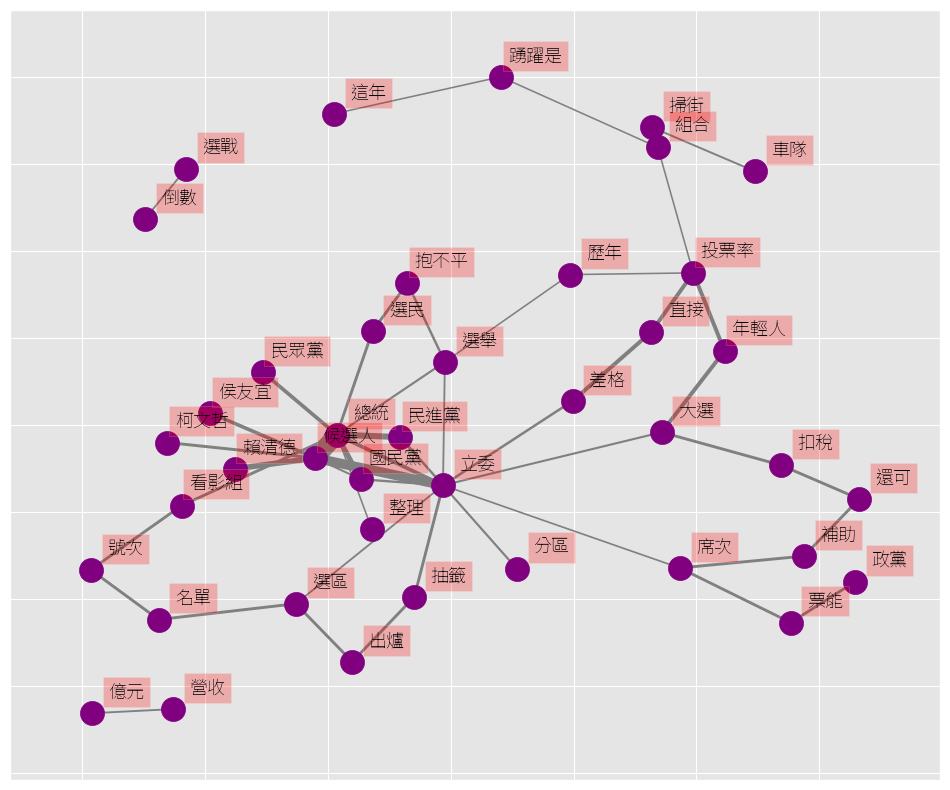

In [111]:
fig, ax = plt.subplots(figsize=(12, 10))

pos = nx.spring_layout(G, k=4)# k越大，斥力越小l;k越小，斥力越大

# networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=weights,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0]+.07, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
plt.show()

**發現** 
+   大部分都與選舉有關， 推測是因為我們選取日期接近總統大選
+   三個黨派會常一起出現，如國民黨、民進黨與民眾黨，推測新聞常進行三黨派對比
+   年輕人會與投票率掛勾，推測是呼籲年輕人返鄉投票 



## 5. Pairwise correlation
計算兩個詞彙間的相關性 Pearson correlation

In [69]:
data_cor = MetaData.copy()

# 需要改成使用空格連接斷好的詞
data_cor['word'] = data_cor.sentence.apply(getToken).map(' '.join)
data_cor.head(3)

,system_id,artTitle,artDate,artCatagory,artUrl,artContent,sentence,word
0,1,蔡總統主持元旦升旗 國防部長邱國正率將領參加,2024/1/1 10:27,要聞,https://udn.com/news/story/10930/7678307,國防部表示，蔡英文總統上午主持中華民國113年元旦總統府升旗典禮，國防部長邱國正、參謀總長梅...,國防部表示蔡英文總統上午主持中華民國年元旦總統府升旗典禮國防部長邱國正參謀總長梅家樹率將領與...,國防部 蔡英文 總統 上午 主持 中華民國 元旦 總統府 升旗典禮 國防部長 邱國正 參謀總...
1,2,F-16V廠級維修能量今年第一季驗證 台美還在對峙談判中,2024/1/1 10:29,要聞,https://udn.com/news/story/10930/7678314,空軍2025年開始陸續接裝66架F-16C/D BLOCK70戰機，國防部軍備局表示，正透過...,空軍年開始陸續接裝架戰機國防部軍備局表示正透過談判爭取由漢翔建立廠級維修中心漢翔公司說維修中...,空軍 陸續 接裝架 戰機 國防部 軍備 透過 談判 爭取 由漢翔 建立 廠級 維修中心 漢翔...
2,3,義務役新兵看過來 入伍結訓震撼教育攻略圖表在這裡,2024/1/1 11:16,要聞,https://udn.com/news/story/10930/7678409,2024年1月首波徵召入營600名一年制兵役役男，這些役男入伍後，將接受新兵訓練震撼教育。國...,年月首波徵召入營名一年制兵役役男這些役男入伍後將接受新兵訓練震撼教育國防部說明震撼教育訓練場...,首波 徵召 入營 一年制 兵役 役男 役男 入伍 後將 接受 新兵訓練 震撼 教育 國防部 ...


In [70]:
# Bag of Word
# 篩選至少出現在5篇文章以上且詞頻前300的詞彙
vectorizer = CountVectorizer(min_df = 5, max_features = 300)
X = vectorizer.fit_transform(data_cor["word"])
vocabulary = vectorizer.get_feature_names_out()

# 轉成dataframe
DTM_df = pd.DataFrame(columns = vocabulary, data = X.toarray())
DTM_df

,一名,一年,上午,上漲,下午,不斷,中共,中國,中國大陸,中央,...,集團,需要,韓國瑜,預估,預計,顯示,飛彈,馬英九,高端,高雄
0,0,1,2,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,2,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9475,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9476,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9477,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
9478,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [71]:
# 計算詞之間的相關係數
corr_matrix = np.corrcoef(DTM_df.T)

# 轉成dataframe
Cor_df = pd.DataFrame(corr_matrix, index = DTM_df.columns, columns = DTM_df.columns)

Cor_df.insert(0, 'word1', Cor_df.columns)
Cor_df.reset_index(inplace = True, drop = True)

Cor_df

,word1,一名,一年,上午,上漲,下午,不斷,中共,中國,中國大陸,...,集團,需要,韓國瑜,預估,預計,顯示,飛彈,馬英九,高端,高雄
0,一名,1.000000,-0.027389,-0.028730,-0.037419,0.002626,0.016746,0.004762,0.005323,-0.026433,...,-0.044919,-0.002925,0.009069,-0.047530,-0.022144,0.015675,0.034706,-0.031603,-0.030018,0.018032
1,一年,-0.027389,1.000000,-0.051522,0.087701,-0.055800,0.032276,-0.024969,0.039043,0.060922,...,0.062945,0.054891,-0.033496,0.054794,0.037265,0.102187,-0.033831,-0.018412,-0.003149,-0.023989
2,上午,-0.028730,-0.051522,1.000000,-0.066083,0.166698,0.074187,0.105445,0.032003,0.016447,...,-0.039833,-0.000378,0.008672,-0.059591,-0.026035,-0.060850,0.065029,0.104680,0.017656,0.047795
3,上漲,-0.037419,0.087701,-0.066083,1.000000,-0.052000,-0.000209,-0.031616,-0.017623,0.001970,...,0.002610,0.001008,-0.030389,0.070776,0.077860,0.133543,-0.025657,-0.028421,-0.027968,-0.039901
4,下午,0.002626,-0.055800,0.166698,-0.052000,1.000000,0.100475,0.112557,0.014522,0.075201,...,-0.048464,-0.007966,0.066143,-0.055966,-0.008234,-0.052628,0.164973,0.046125,-0.003014,0.052910
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,顯示,0.015675,0.102187,-0.060850,0.133543,-0.052628,-0.016166,0.012747,0.033488,0.013082,...,0.002051,0.012231,-0.039514,0.067267,0.032261,1.000000,0.002341,-0.030342,-0.009875,-0.038906
296,飛彈,0.034706,-0.033831,0.065029,-0.025657,0.164973,-0.024737,0.438292,0.086020,0.314842,...,-0.015672,0.005614,-0.011782,-0.029827,-0.021468,0.002341,1.000000,0.013249,-0.008271,0.004785
297,馬英九,-0.031603,-0.018412,0.104680,-0.028421,0.046125,0.034160,0.013972,0.103099,0.002109,...,0.016381,-0.008539,0.028513,-0.027858,-0.029861,-0.030342,0.013249,1.000000,-0.000531,0.013075
298,高端,-0.030018,-0.003149,0.017656,-0.027968,-0.003014,0.034358,-0.002883,-0.005113,-0.016678,...,-0.013432,0.040779,-0.002148,-0.033479,-0.032505,-0.009875,-0.008271,-0.000531,1.000000,-0.003768


In [72]:
word_cor_df = Cor_df.melt(id_vars = 'word1', var_name = 'word2', value_name = 'cor')

# 去除兩個詞相同的情況
word_cor_df = word_cor_df[word_cor_df["word1"] != word_cor_df["word2"]]

word_cor_df.sort_values('cor', ascending=False).head(10)

,word1,word2,cor
61612,扣稅,看影組,0.999692
33805,看影組,扣稅,0.999692
35305,看影組,抱不平,0.998775
61617,抱不平,看影組,0.998775
35212,扣稅,抱不平,0.998467
33717,抱不平,扣稅,0.998467
61708,票能,看影組,0.987673
62605,看影組,票能,0.987673
33808,票能,扣稅,0.987369
62512,扣稅,票能,0.987369


In [73]:
word_cor_df

,word1,word2,cor
1,一年,一名,-0.027389
2,上午,一名,-0.028730
3,上漲,一名,-0.037419
4,下午,一名,0.002626
5,不斷,一名,0.016746
...,...,...,...
89994,預計,高雄,0.011863
89995,顯示,高雄,-0.038906
89996,飛彈,高雄,0.004785
89997,馬英九,高雄,0.013075


### 5.1 和 「總統」, 「高雄」 相關性最高的 10 個詞彙

In [89]:
stopword_list = ['差格','還可','抱不平','看影組']  # 停用词列表

p = word_cor_df[~word_cor_df["word2"].isin(stopword_list) & (word_cor_df["word1"] == "總統")].sort_values(by='cor', ascending=False).head(10)
k = word_cor_df[~word_cor_df["word2"].isin(stopword_list) & (word_cor_df["word1"] == "高雄")].sort_values(by='cor', ascending=False).head(10)

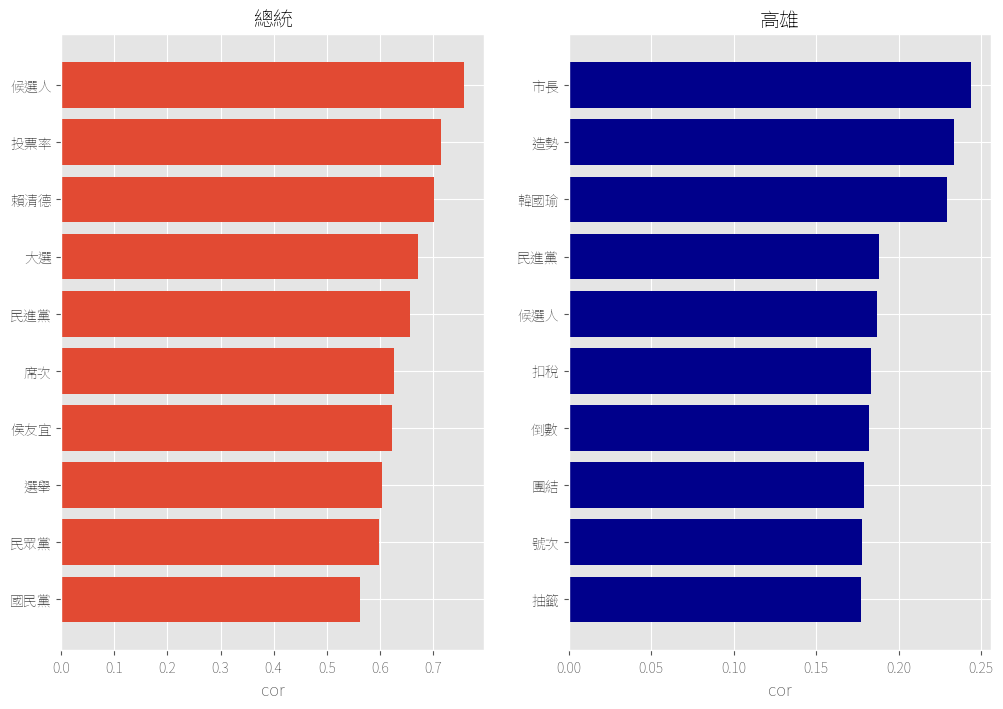

In [90]:
plt.figure(figsize=(12,8))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式

plt.subplot(121)
plt.title('總統')
plt.xlabel('cor')
plt.barh(p['word2'],p['cor'])
plt.gca().invert_yaxis()

plt.subplot(122)
plt.title('高雄')
plt.xlabel('cor')
plt.barh(k['word2'],k['cor'],color="darkblue")
plt.gca().invert_yaxis()

plt.show()

本資料集選擇的時間是總統大選前一個月，可以發現和總統相關的關鍵字有**候選人、投票率、賴清德**等相關詞。  
和高雄相關的關鍵字則是有**市長、造勢、韓國瑜**等與高雄，推測是大選前的造勢活動，韓國瑜有幫忙站台，而他與高雄關係密切。

### 5.2 使用詞彙關係圖畫出以詞頻前60為節點且相關性高於0.5的組合

In [47]:
# 透過DTM找出詞頻前60高的詞彙
most_freq_df = DTM_df.sum().sort_values(ascending=False).head(60).reset_index().rename(columns={'index':'word', 0:'count'})

most_freq_word = most_freq_df['word'].tolist()

In [48]:
# 保留存在詞頻前60高之詞彙的組合
filtered_df = word_cor_df[(word_cor_df['word1'].isin(most_freq_word)) & (word_cor_df['word2'].isin(most_freq_word))]

# 篩選出相關係數大於0.35的組合
filtered_df = filtered_df[filtered_df['cor'] > 0.5]
filtered_df.reset_index(inplace=True, drop=True)
filtered_df

,word1,word2,cor
0,總統,侯友宜,0.622192
1,候選人,倒數,0.573270
2,差格,倒數,0.662463
3,席次,倒數,0.517222
4,民進黨,倒數,0.516064
...,...,...,...
201,民進黨,選舉,0.603744
202,立委,選舉,0.632841
203,總統,選舉,0.604001
204,選區,選舉,0.512324


In [49]:
# Create network plot 
g = nx.Graph()

# 建立 nodes 間的連結
for i in range(len(filtered_df)):
    g.add_edge(filtered_df["word1"][i], filtered_df["word2"][i], weight=filtered_df["cor"][i])
    
# 取得edge權重
weights = [w[2]['weight']*3 for w in  g.edges(data=True)]

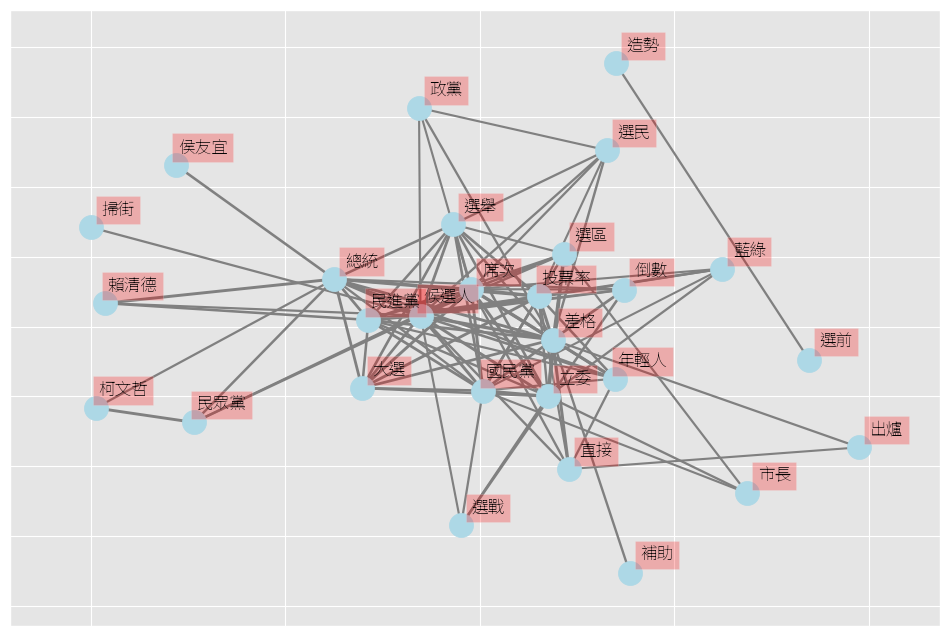

In [50]:
fig, ax = plt.subplots(figsize=(12, 8))

pos = nx.spring_layout(g, k=1)

# networks
nx.draw_networkx(g, pos,
                 font_size=16,
                 width=weights,
                 edge_color='grey',
                 node_color='lightblue',
                 with_labels = False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0]+.07, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=12)
    
plt.show()

詞頻前60為節點且相關性高於0.5的組合中，可以發現候選人都會與其政黨相關，除了國民黨與侯友宜沒有連到線，原因是兩者關聯0.45，小於0.5，相對於其他兩組候選人沒這麼強烈。

In [51]:
word_cor_df[(word_cor_df['word1']=='國民黨')&(word_cor_df['word2']=='侯友宜')]

,word1,word2,cor
7268,國民黨,侯友宜,0.451089


In [52]:
word_cor_df[(word_cor_df['word1']=='民進黨')&(word_cor_df['word2']=='賴清德')]

,word1,word2,cor
77875,民進黨,賴清德,0.60707


In [53]:
word_cor_df[(word_cor_df['word1']=='民眾黨')&(word_cor_df['word2']=='柯文哲')]

,word1,word2,cor
49373,民眾黨,柯文哲,0.693114


## 6. 計算文章相似度
以TF-IDF的結果當作文章的向量，計算 Cosine Similarity 找出相似的文章   

<img src="./img/pic3.PNG" style="float:left;" width="50%">  

In [54]:
data_cos = data_cor.copy()
data_cos.head(3)

,system_id,artTitle,artDate,artCatagory,artUrl,artContent,sentence,word
0,1,蔡總統主持元旦升旗 國防部長邱國正率將領參加,2024/1/1 10:27,要聞,https://udn.com/news/story/10930/7678307,國防部表示，蔡英文總統上午主持中華民國113年元旦總統府升旗典禮，國防部長邱國正、參謀總長梅...,國防部表示蔡英文總統上午主持中華民國年元旦總統府升旗典禮國防部長邱國正參謀總長梅家樹率將領與...,國防部 蔡英文 總統 上午 主持 中華民國 元旦 總統府 升旗典禮 國防部長 邱國正 參謀總...
1,2,F-16V廠級維修能量今年第一季驗證 台美還在對峙談判中,2024/1/1 10:29,要聞,https://udn.com/news/story/10930/7678314,空軍2025年開始陸續接裝66架F-16C/D BLOCK70戰機，國防部軍備局表示，正透過...,空軍年開始陸續接裝架戰機國防部軍備局表示正透過談判爭取由漢翔建立廠級維修中心漢翔公司說維修中...,空軍 陸續 接裝架 戰機 國防部 軍備 透過 談判 爭取 由漢翔 建立 廠級 維修中心 漢翔...
2,3,義務役新兵看過來 入伍結訓震撼教育攻略圖表在這裡,2024/1/1 11:16,要聞,https://udn.com/news/story/10930/7678409,2024年1月首波徵召入營600名一年制兵役役男，這些役男入伍後，將接受新兵訓練震撼教育。國...,年月首波徵召入營名一年制兵役役男這些役男入伍後將接受新兵訓練震撼教育國防部說明震撼教育訓練場...,首波 徵召 入營 一年制 兵役 役男 役男 入伍 後將 接受 新兵訓練 震撼 教育 國防部 ...


In [55]:
transformer = TfidfTransformer()  
print(transformer) 
# 將詞頻矩陣X統計成TF-IDF值
tfidf = transformer.fit_transform(X)  

# 轉成dataframe
TFIDF_df = pd.DataFrame(columns = vocabulary, data = tfidf.toarray())
TFIDF_df

TfidfTransformer()


,一名,一年,上午,上漲,下午,不斷,中共,中國,中國大陸,中央,...,集團,需要,韓國瑜,預估,預計,顯示,飛彈,馬英九,高端,高雄
0,0.0,0.060145,0.10134,0.0,0.000000,0.000000,0.0,0.050324,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.0,0.102732,0.00000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.197492,0.0,0.0,0.0,0.0,0.0
2,0.0,0.092168,0.00000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.0,0.172120,0.00000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,0.0,0.084105,0.00000,0.0,0.073115,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9475,0.0,0.000000,0.00000,0.0,0.000000,0.125691,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
9476,0.0,0.000000,0.00000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
9477,0.0,0.000000,0.00000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.205319,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
9478,0.0,0.000000,0.00000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


計算文章間的cosine similarity

In [56]:
cosine_matrix = cosine_similarity(tfidf.toarray(), tfidf.toarray())

檢視與第三篇文章相似的文章 : "義務役新兵看過來 入伍結訓震撼教育攻略圖表在這裡"

In [57]:
cos_df = pd.DataFrame(cosine_matrix[2], columns = ['cos_similarity'])
cos_df

,cos_similarity
0,0.807745
1,0.591959
2,1.000000
3,0.884668
4,0.869453
...,...
9475,0.025957
9476,0.000000
9477,0.000000
9478,0.000000


In [58]:
cos_df = cos_df.merge(data_cos, how = 'left', left_index=True, right_index=True)
cos_df.loc[:,["cos_similarity", "artTitle", "artUrl"]].sort_values(by=['cos_similarity'], ascending=False).head(10)

,cos_similarity,artTitle,artUrl
2,1.000000,義務役新兵看過來 入伍結訓震撼教育攻略圖表在這裡,https://udn.com/news/story/10930/7678409
5,0.888235,國防部：國軍廉能施政已獲國際肯定,https://udn.com/news/story/10930/7679196
3,0.884668,國防部：籲法界嚴肅看待暴行、抗命及聚眾鬥毆軍紀案,https://udn.com/news/story/10930/7678652
4,0.869453,暴行抗命等軍紀案 國防部：檢察官允速查嚴辦,https://udn.com/news/story/10930/7679055
0,0.807745,蔡總統主持元旦升旗 國防部長邱國正率將領參加,https://udn.com/news/story/10930/7678307
53,0.807467,義務役男分配國軍優先 海巡署 國安局提需未獲兵額,https://udn.com/news/story/10930/7692894
46,0.788988,役男參戰 國防部：戰事爆發無前後方之分處處皆戰場,https://udn.com/news/story/10930/7691880
42,0.785096,停辦國防學士班 國防部：其他班隊招獲率百分之百,https://udn.com/news/story/10930/7691327
43,0.778045,國防部：持續修訂加給支給規定 提升招募留營誘因,https://udn.com/news/story/10930/7691359
47,0.750716,1年制義務役首波25日入伍 新兵鑑測未過要補訓,https://udn.com/news/story/10930/7692284


發現與文章"義務役新兵看過來 入伍結訓震撼教育攻略圖表在這裡"相關的文章都會與國防部與兵役有關

## 7. 建立Ngram預測模型

In [59]:
data3 = MetaData.copy()
sen_tokens = data3.sentence.apply(getToken).tolist()

In [60]:
def ngram(documents, N=2):
    ngram_prediction = dict()
    total_grams = list()
    words = list()
    Word = namedtuple('Word', ['word', 'prob'])

    for doc in documents:
        # 加上開頭和結尾 tag
        split_words = ['<s>'] + list(doc) + ['</s>']
        # 計算分子
        [total_grams.append(tuple(split_words[i:i+N])) for i in range(len(split_words)-N+1)]
        # 計算分母
        [words.append(tuple(split_words[i:i+N-1])) for i in range(len(split_words)-N+2)]
        
    total_word_counter = Counter(total_grams)
    word_counter = Counter(words)
    
    for key in total_word_counter:
        word = ''.join(key[:N-1])
        if word not in ngram_prediction:
            ngram_prediction.update({word: set()})
            
        next_word_prob = total_word_counter[key]/word_counter[key[:N-1]] #P(B|A)
        w = Word(key[-1], '{:.3g}'.format(next_word_prob))
        ngram_prediction[word].add(w)
        
    return ngram_prediction

### 以Bigram預測下一個出現的詞

因為本資料集的時間是總統大選前一個月，故以"總統大選"相關詞彙作為預測。

In [61]:
bi_prediction = ngram(sen_tokens, N=2)

In [92]:
text = '大選'
next_words = list(bi_prediction[text])
next_words.sort(key = lambda s: s[1], reverse = True)
for next_word in next_words[:5]:
    print('next word: {}, probability: {}'.format(next_word.word, next_word.prob))

next word: 年輕人, probability: 0.409
next word: 倒數, probability: 0.0766
next word: 今日, probability: 0.0688
next word: 開票, probability: 0.0585
next word: 投票, probability: 0.0529


發現大選預測下一個詞友年輕人、倒數、今日、開票、投票。其中年輕人推測是呼籲年輕人返鄉投票

In [93]:
text = '年輕人'
next_words = list(bi_prediction[text])
next_words.sort(key = lambda s: s[1], reverse = True)
for next_word in next_words[:5]:
    print('next word: {}, probability: {}'.format(next_word.word, next_word.prob))

next word: 投票率, probability: 0.813
next word: 機會, probability: 0.00456
next word: 投票, probability: 0.0037
next word: 返鄉, probability: 0.0037
next word: 支持, probability: 0.00342


由上面的預測的確可以發現，年輕人相關詞友包括返鄉、支持等呼籲性字詞

接著，我們探討總統候選人的預測字詞

In [63]:
text = '賴清德'
next_words = list(bi_prediction[text])
next_words.sort(key = lambda s: s[1], reverse = True)
for next_word in next_words[:5]:
    print('next word: {}, probability: {}'.format(next_word.word, next_word.prob))

next word: 蕭美琴, probability: 0.0854
next word: 今天, probability: 0.035
next word: 日前, probability: 0.0312
next word: 贊成, probability: 0.0243
next word: 競選, probability: 0.0211


In [64]:
text = '侯友宜'
next_words = list(bi_prediction[text])
next_words.sort(key = lambda s: s[1], reverse = True)
for next_word in next_words[:5]:
    print('next word: {}, probability: {}'.format(next_word.word, next_word.prob))

next word: 趙少康, probability: 0.0615
next word: 民進黨, probability: 0.0428
next word: 總統, probability: 0.0393
next word: 賴清德, probability: 0.0376
next word: 今天, probability: 0.0321


In [94]:
text = '柯文哲'
next_words = list(bi_prediction[text])
next_words.sort(key = lambda s: s[1], reverse = True)
for next_word in next_words[:5]:
    print('next word: {}, probability: {}'.format(next_word.word, next_word.prob))

next word: 今天, probability: 0.0824
next word: 競選, probability: 0.0431
next word: 總統, probability: 0.0375
next word: 吳欣盈, probability: 0.0335
next word: 柯文哲, probability: 0.0258


從上面三個候選人預測發現，總統候選人副手名字出現的機率很高  
有趣的發現 : 為何侯友宜的預測詞會有民進黨呢?結合前面相關性分析時的發現(侯友宜跟國民黨的相關性比其他兩組候選人低)，似乎比起國民黨，侯友宜比較